In [16]:
# Import library
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from datetime import datetime

import xgboost as xgb
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import time
from tqdm import tqdm_notebook as tqdm
from IPython.display import IFrame

# Ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

# Set the seed for randomization
seed = 0

In [2]:
# def download_file(url):
#     '''
#     Download file from given URL
    
#     Parameters
#     ----------
#     url: str
#         URL of the file to download
#     '''
    
#     # One chunk = 1KB = 1024 byte
#     chunk_size = 1024
#     # Create a request object to download the file in streaming mode
#     r = requests.get(url, stream = True)
#     # Get the total size of the file
#     total_size = int(r.headers['content-length'])
#     # Use the original filename (The string after the last "/")
#     filename = url.split('/')[-1]
    
#     # Open a new file with filename and write the download data
#     with open(filename, 'wb') as f:
#         # Use tqdm to show download progress
#         for data in tqdm(iterable = r.iter_content(chunk_size = chunk_size), 
#                          total = total_size/chunk_size, unit ='KB'):
#             # Write the data to file
#             f.write(data)
            
#     print('Donwload complete')

In [3]:
# # The URL of the Green Taxis data from September 2015
# url = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-01.csv"

In [5]:
# # Download the file
# download_file(url)

Donwload complete


In [129]:
data = pd.read_csv('../data/yellow_tripdata_2018-01.csv')
data.shape

(8759874, 17)

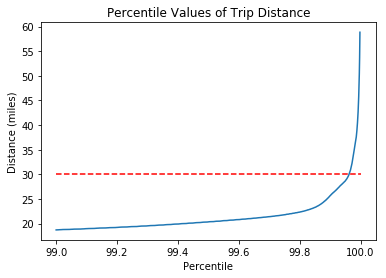

In [107]:
# Compute the value of Trip_distance for percentiles of 99.000, 99.001, ..., 99.999
X = np.arange(99,99.999,0.001)
Y = [np.percentile(data.trip_distance, x) for x in X]
# Visualize the percentile values
ax = sns.lineplot(x = X, y = Y)
ax.hlines(30, xmin = 99, xmax = 100, colors = 'red', linestyles='dashed') # Add horizontal red dashed line at 30
ax.set_title('Percentile Values of Trip Distance');
ax.set_xlabel('Percentile'); ax.set_ylabel('Distance (miles)');

In [110]:
# The percentile that has value of 30 for Trip_distance
print('Roughly {:.2f}% of the trip records have Trip_distance roughly less than 30 miles'
      .format(X[min(range(len(Y)), key = lambda i: abs(Y[i]-30))])) 

Roughly 99.96% of the trip records have Trip_distance roughly less than 30 miles


In [133]:
def taxi_data_preprocess(taxi_data):
    # Convert data type for categorical attribute
    taxi_data.VendorID = taxi_data.VendorID.astype(object)
    taxi_data.RatecodeID = taxi_data.RatecodeID.astype(object)
    taxi_data.PULocationID = taxi_data.PULocationID.astype(object)
    taxi_data.DOLocationID = taxi_data.DOLocationID.astype(object)
    taxi_data.payment_type = taxi_data.payment_type.astype(object)
    # Convert data type for date attribute
    taxi_data.tpep_pickup_datetime = pd.to_datetime(taxi_data.tpep_pickup_datetime)
    taxi_data.tpep_dropoff_datetime = pd.to_datetime(taxi_data.tpep_dropoff_datetime)
    
    # Compute the duration of each trip and store in a new column, 'duration'
    print('Compute the duration of each taxi trip...')
    taxi_data['duration'] = taxi_data.tpep_dropoff_datetime - taxi_data.tpep_pickup_datetime
    # Remove unreasonable records
    print('Remove unreasonable records...')
    # 1. Taxi trips that last longer than 24 hours
    print('Remove trip records that last longer than 24 hours...')
    taxi_data = taxi_data.loc[[duration.days == 0 for duration in taxi_data.duration],]
    # 2. Taxi trips that travel more than 30 miles
    print('Remove trip records that travel more than 30 miles...')
    taxi_data = taxi_data.loc[taxi_data.trip_distance <= 30,]
    # 3. Taxi trips with non-positive total amount 
    print('Remove trip records that have negative or zero total amount...')
    taxi_data = taxi_data.loc[taxi_data.total_amount > 0,]
    
    print('Taxi data preprocess completed!')
    
    return taxi_data

In [134]:
# Load the csv file into pandas dataframe
taxi_data = pd.read_csv('../data/yellow_tripdata_2018-01.csv')
# Preprocess the taxi data
taxi_data = taxi_data_preprocess(taxi_data)

Compute the duration of each taxi trip...
Remove unreasonable records...
Remove trip records that last longer than 24 hours...
Remove trip records that travel more than 30 miles...
Remove trip records that have negative or zero total amount...
Taxi data preprocess completed!


In [135]:
taxi_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.5,1,N,41,24,2,4.5,0.5,0.5,0.00,0.0,0.3,5.80,00:03:18
1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.7,1,N,239,140,2,14.0,0.5,0.5,0.00,0.0,0.3,15.30,00:18:10
2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.8,1,N,262,141,1,6.0,0.5,0.5,1.00,0.0,0.3,8.30,00:05:55
3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.2,1,N,140,257,2,33.5,0.5,0.5,0.00,0.0,0.3,34.80,00:32:29
4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.5,1,N,246,239,1,12.5,0.5,0.5,2.75,0.0,0.3,16.55,00:17:48


In [136]:
taxi_data.shape

(8751243, 18)

In [132]:
taxi_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
58,2,2018-01-01 01:02:39,2018-01-01 01:04:02,2,0.09,1,N,87,87,4,-3.0,-0.5,-0.5,0.0,0.0,-0.3,-4.3,00:01:23
840,2,2018-01-01 00:38:19,2018-01-01 00:55:57,1,0.41,1,N,68,68,4,-11.0,-0.5,-0.5,0.0,0.0,-0.3,-12.3,00:17:38
3862,2,2018-01-01 00:46:31,2018-01-01 00:46:34,1,0.00,5,N,264,238,4,-13.8,0.0,0.0,0.0,0.0,-0.3,-14.1,00:00:03
4084,2,2018-01-01 00:47:40,2018-01-01 00:49:06,1,0.13,1,N,137,137,3,-3.0,-0.5,-0.5,0.0,0.0,-0.3,-4.3,00:01:26
4242,2,2018-01-01 00:11:10,2018-01-01 00:15:14,1,0.16,1,N,137,170,4,-4.5,-0.5,-0.5,0.0,0.0,-0.3,-5.8,00:04:04


In [77]:
t = data.duration[[duration.days != 0 for duration in data.duration]]

In [79]:
t

158864    -4 days +00:48:25
754026      1 days 01:19:50
2647622     3 days 17:42:04
4964225     3 days 04:55:04
6145573   -1 days +11:16:06
7162239     2 days 16:22:13
dtype: timedelta64[ns]

In [71]:
data.duration[6145573]

Timedelta('-1 days +11:16:06')

In [74]:
data.duration[6145573].days

-1

In [65]:
data.duration.describe()

count                   8759874
mean     0 days 00:15:39.703117
std      0 days 01:00:20.398610
min           -4 days +00:48:25
25%             0 days 00:06:14
50%             0 days 00:10:22
75%             0 days 00:16:50
max             3 days 17:42:04
dtype: object

In [62]:
data.duration[0].seconds

198

TypeError: Cannot cast ufunc less input from dtype('float64') to dtype('<m8[ns]') with casting rule 'same_kind'

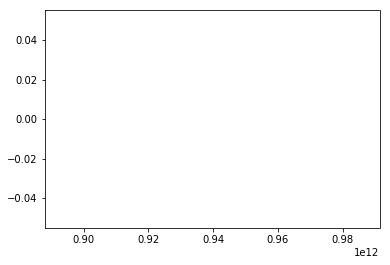

In [54]:
sns.distplot(data.duration)

In [103]:
def fall_into(warning, taxi_trip):
    if taxi_trip.tpep_pickup_datetime > warning.start and taxi_trip.tpep_dropoff_datetime < warning.end:
        return True
    else:
        return False

In [ ]:
def add_weather(taxi_path, weather_path):
    # Read weather data
    weather_data = pd.read_csv(weather_path)
    # Remove warning duplicates
    weather_data.drop_duplicates(inplace=True)
    

In [86]:
weather_data = pd.read_csv('../data/NYC_2018_weather.csv')
weather_data.drop_duplicates(inplace=True)
weather_data.reset_index(inplace=True, drop=True)
weather_data.start = [datetime.strptime(str(time),'%Y%m%d%H%M') for time in weather_data.start]
weather_data.end = [datetime.strptime(str(time),'%Y%m%d%H%M') for time in weather_data.end]

In [87]:
weather_data

,PHENOM,start,end
0,WS,2018-01-03 20:20:00,2018-01-05 06:00:00
1,WS,2018-02-17 08:32:00,2018-02-18 12:00:00
2,WS,2018-03-06 08:49:00,2018-03-08 09:00:00
3,WS,2018-03-07 09:11:00,2018-03-08 09:00:00
4,WS,2018-03-20 07:44:00,2018-03-22 12:00:00
5,SV,2018-05-15 20:51:00,2018-05-15 21:45:00
6,SV,2018-05-15 21:28:00,2018-05-15 22:15:00
7,SV,2018-07-27 20:45:00,2018-07-27 21:30:00
8,SV,2018-07-27 21:14:00,2018-07-27 22:00:00
9,TO,2018-08-03 02:18:00,2018-08-03 02:45:00


In [34]:
data.tpep_dropoff_datetime[800000]

Timestamp('2018-01-04 12:06:28')

In [95]:
weather_data.iloc[0,]

Timestamp('2018-01-03 20:20:00')

In [99]:
data.iloc[800000,]['tpep_dropoff_datetime']

Timestamp('2018-01-04 12:06:28')

In [104]:
fall_into(warning = weather_data.iloc[0,], taxi_trip=data.iloc[800000,])

True

In [18]:
datetime.strptime(str(weather_data.start[0]),'%Y%m%d%H%M')

datetime.datetime(2018, 1, 3, 20, 20)

In [20]:
datetime.strptime(str(weather_data.start[0]),'%Y%m%d%H%M') < data.tpep_dropoff_datetime[0]

False

In [22]:
type(datetime.strptime(str(weather_data.start[0]),'%Y%m%d%H%M'))

datetime.datetime

In [23]:
type(data.tpep_dropoff_datetime[0])

pandas._libs.tslibs.timestamps.Timestamp